<a href="https://colab.research.google.com/github/eshwar7777/wildAI/blob/main/wildAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
























































































































































































































































































































































































































































































































































































































































































































##Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Mount the Google Drive to Google Colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Declaring a variable to be used refer to the dataset

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/ProbeSet')

In [ ]:
'''from pathlib import Path
import imghdr

#data_dir = "/home/user/datasets/samples/"
image_extensions = [".png", ".jpg", ".jpeg", ".bmp", ".gif", ".txt"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")'''

'from pathlib import Path\nimport imghdr\n\n#data_dir = "/home/user/datasets/samples/"\nimage_extensions = [".png", ".jpg", ".jpeg", ".bmp", ".gif", ".txt"]  # add there all your images file extensions\n\nimg_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]\nfor filepath in Path(data_dir).rglob("*"):\n    if filepath.suffix.lower() in image_extensions:\n        img_type = imghdr.what(filepath)\n        if img_type is None:\n            print(f"{filepath} is not an image")\n        elif img_type not in img_type_accepted_by_tf:\n            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")'

https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required

# Counting the total numbers of images in dataset

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

22930


# Creating a list of images present under the directory with the label "elephant"

Also opening its first image

11400


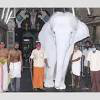

In [ ]:
elephant = list(data_dir.glob('Elephant/*'))
print(len(elephant))
PIL.Image.open(str(elephant[0]))

Now opening its second image

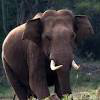

In [ ]:
PIL.Image.open(str(elephant[1]))

# Creating a list of images present under the directory with the label "NotElephant"

Also opening its first image

11531


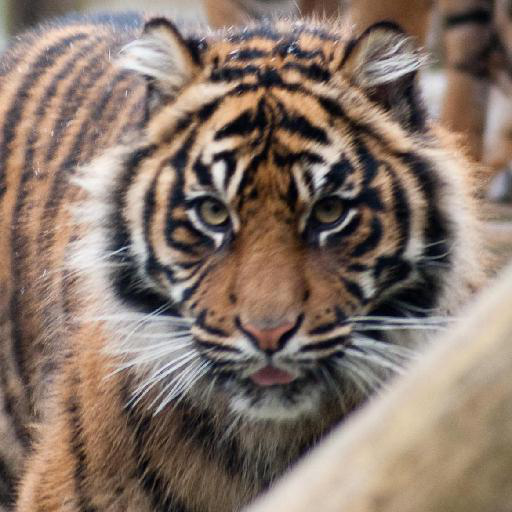

In [ ]:
NotElephant = list(data_dir.glob('NotElephant/*'))
print(len(NotElephant))
PIL.Image.open(str(NotElephant[0]))

Now opening its second image

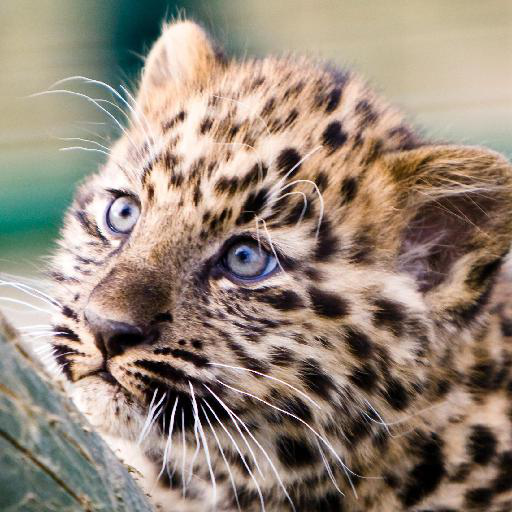

In [ ]:
PIL.Image.open(str(NotElephant[1]))

# Define some parameters for the loader:

In [ ]:
batch_size = 9
img_height = 180
img_width = 180

# Validation split while developing the model

Using 80% of the images for training, and 20% for validation

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22931 files belonging to 2 classes.
Using 18345 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22931 files belonging to 2 classes.
Using 4586 files for validation.


# Finding the class names

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Elephant', 'NotElephant']


# Visualize the data

First nine images from the training dataset:

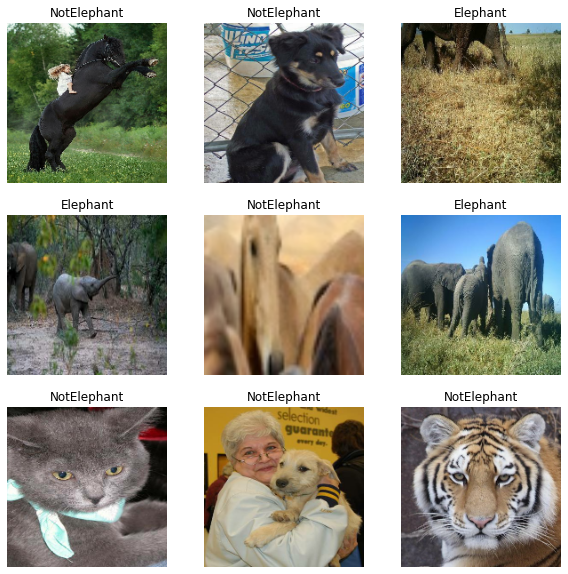

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Manually iterating over the dataset and retrieving batches of images

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(9, 180, 180, 3)
(9,)


# Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

Applying it to the dataset to use this layer by calling Dataset.map

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Define a model



In [ ]:
num_classes = len(class_names)
def create_model():
  model = Sequential([
                      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                      layers.Conv2D(16, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(),
                      #layers.Conv2D(64, 3, padding='same', activation='relu'),
                      #layers.MaxPooling2D(),
                      layers.Flatten(),
                      layers.Dense(128, activation='relu'),
                      layers.Dense(num_classes)
                      ])
  
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

## Create a basic model instance

In [ ]:
model = create_model()

## Display the model's architecture

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0

## Train the model

In [ ]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

2039/2039 [==============================] - 1308s 626ms/step - loss: 0.3477 - accuracy: 0.8462 - val_loss: 0.2929 - val_accuracy: 0.8687


## Visualize training results

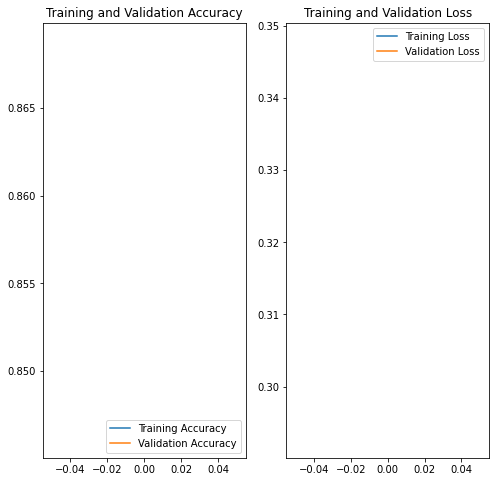

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting -> Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualizing what a few augmented examples look like by applying data augmentation to the same image several times

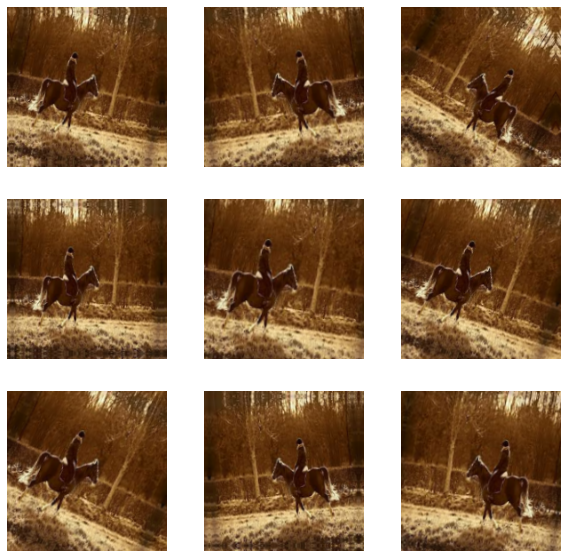

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

2039/2039 [==============================] - 23s 11ms/step - loss: 0.3790 - accuracy: 0.8253 - val_loss: 0.2937 - val_accuracy: 0.8698


In [ ]:
normalization_layer = layers.Rescaling(1./255)
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(norm_val_ds))

In [ ]:
model.save('/content/drive/MyDrive/mymodelL.h5', save_format="h5")

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/mymodelL.h5')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
print(len(images))

9


In [ ]:
test_loss, test_acc = new_model.evaluate(norm_val_ds, verbose=2)
print('Test accuracy:', test_acc)

510/510 - 2s - loss: 1.7919 - accuracy: 0.4884 - 2s/epoch - 5ms/step
Test accuracy: 0.4884430766105652


## Visualize training results

In [ ]:
model.save('/content/drive/MyDrive/mymodel8.h5', save_format="h5")


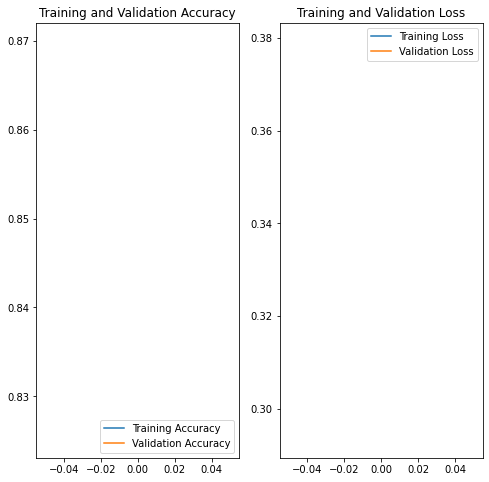

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [ ]:
'''from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/mymodel5.h5')'''


"from tensorflow import keras\nmodel = keras.models.load_model('/content/drive/MyDrive/mymodel5.h5')"

In [ ]:
elephant_url = "https://1.bp.blogspot.com/-WLtOEjAK3RY/UAAwfdpEIjI/AAAAAAAAMzs/cEwvMngLSbw/s1600/Elephant10.jpg"
elephant_path = tf.keras.utils.get_file('b', origin=elephant_url)

img = tf.keras.utils.load_img(
    elephant_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

425984/413011 [==============================] - 0s 0us/step
This image most likely belongs to NotElephant with a 55.41 percent confidence.
